# XGBoost

## Import Data

In [2]:
import numpy as np
import pandas as pd

train_df = pd.read_parquet("../data/train_non_lin_preprocessed.parquet")
print(train_df.shape)

X_train = train_df.drop(columns = ['target'])
y_train = train_df['target']

test_df = pd.read_parquet("../data/test_non_lin_preprocessed.parquet")
print(test_df.shape)

X_test = test_df.drop(columns = ['target'])
y_test = test_df['target']

(1076248, 80)
(269062, 80)


## Modelling

In [3]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, roc_curve
import matplotlib.pyplot as plt

In [4]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb_model = xgb.XGBClassifier(
    n_estimators=400,        # number of trees
    max_depth=5,            # depth of trees
    learning_rate=0.1,       # shrinkage
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    eval_metric='auc',       # track ROC AUC
    tree_method='gpu_hist',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_proba = xgb_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print("XGBoost ROC AUC:", auc_score)

scale_pos_weight: 4.00936945826565


c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:2676: UserWarning: [21:47:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:47:48] WARNING: C:\actions-runner\_work\xgboos

XGBoost ROC AUC: 0.7352468432020971


In [5]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

PR AUC: 0.4112528814692863


In [6]:
cost_fn = 10  # relative cost
cost_fp = 1

thresholds = np.linspace(0, 1, 101)
best_threshold, best_cost = 0, float('inf')

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    FN = np.sum((y_test==1) & (y_pred==0))
    FP = np.sum((y_test==0) & (y_pred==1))
    cost = FN*cost_fn + FP*cost_fp
    
    if cost < best_cost:
        best_cost = cost
        best_threshold = t

print("Best threshold:", best_threshold)
print("Min expected cost:", best_cost)

Best threshold: 0.29
Min expected cost: 188056


In [7]:
y_pred = (y_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred))
print()

y_pred = (y_proba >= 0.45).astype(int) # 5:1 cost_fn:cost_fp
print(classification_report(y_test, y_pred))
print()

y_pred = (y_proba >= 0.29).astype(int) # 10:1 cost_fn:cost_fp
print(classification_report(y_test, y_pred))
print()

y_pred = (y_proba >= 0.18).astype(int) # 20:1 cost_fn:cost_fp
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.66      0.76    215350
           1       0.33      0.68      0.45     53712

    accuracy                           0.66    269062
   macro avg       0.61      0.67      0.60    269062
weighted avg       0.78      0.66      0.70    269062


              precision    recall  f1-score   support

           0       0.91      0.57      0.70    215350
           1       0.31      0.76      0.44     53712

    accuracy                           0.61    269062
   macro avg       0.61      0.67      0.57    269062
weighted avg       0.79      0.61      0.65    269062


              precision    recall  f1-score   support

           0       0.95      0.30      0.45    215350
           1       0.25      0.93      0.39     53712

    accuracy                           0.42    269062
   macro avg       0.60      0.61      0.42    269062
weighted avg       0.81      0.42      0.44    269062


              pr

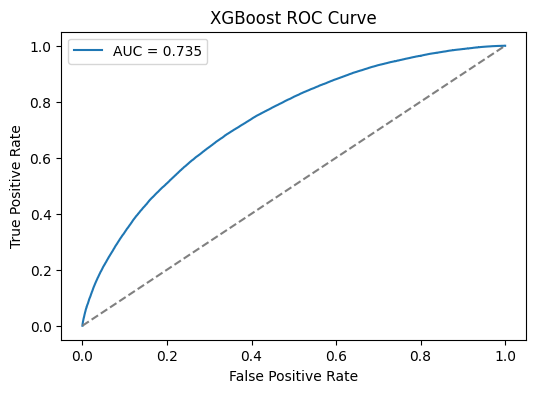

In [8]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()

## Hyperparameter Tuning

In [41]:
# The dataset is too large to use cross validation with multiple folds to tune hyperparameters
# so let's take a small sample of the data instead

train_sample = train_df.sample(frac=0.25, random_state=42)  # 10% of data
X_sample = train_sample.drop(columns=["target"])
y_sample = train_sample["target"]

In [42]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, ParameterGrid

In [43]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

In [44]:
# Note that I first narrowed down param_grid and I'm now looking more locally.

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.75, 0.8, 0.85]
}

best_auc = 0
best_params = {}

for params in ParameterGrid(param_grid):
    model = xgb.XGBClassifier(
        n_estimators=5000,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        subsample = params['subsample'],
        colsample_bytree = 1,  # Used the param_grid to determine 1 is the best
        scale_pos_weight=scale_pos_weight,
        early_stopping_rounds=50,
        device='cuda',
        eval_metric='auc',
        random_state=42
    )

    model.fit(
        X_train_sub, y_train_sub,
        eval_set=[(X_val_sub, y_val_sub)],    
        verbose=False
    )

    y_proba = model.predict_proba(X_val_sub)[:, 1]
    roc = roc_auc_score(y_val_sub, y_proba)

    precision, recall, _ = precision_recall_curve(y_val_sub, y_proba)
    pr_auc = auc(recall, precision)

    if roc > best_auc:
        best_auc = roc
        best_params = params
        best_iteration = model.best_iteration
        best_params_pr_auc = pr_auc

print()
print("✅ Best params:", best_params, "| Best Iteration:", best_iteration,"| Best Validation AUC:", best_auc, "| Validation PR AUC:", best_params_pr_auc)

scale_pos_weight: 4.00936945826565

✅ Best params: {'learning_rate': 0.03, 'max_depth': 3, 'subsample': 0.75} | Best Iteration: 1990 | Best Validation AUC: 0.7295017299103576 | Validation PR AUC: 0.3993879448839742


In [ ]:
import xgboost as xgb

final_model = xgb.XGBClassifier(
    n_estimators=5000,              # big enough for early stopping
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params.get('subsample', 1.0),
    colsample_bytree=1,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=50,
    device='cuda',
    eval_metric='auc',
    random_state=42
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=2
)

print("Best iteration:", final_model.best_iteration)
print("Best score (AUC):", final_model.best_score)

[0]	validation_0-auc:0.69098
[2]	validation_0-auc:0.69855
[4]	validation_0-auc:0.70021
[6]	validation_0-auc:0.70152
[8]	validation_0-auc:0.70222
[10]	validation_0-auc:0.70328
[12]	validation_0-auc:0.70406
[14]	validation_0-auc:0.70529
[16]	validation_0-auc:0.70641
[18]	validation_0-auc:0.70743
[20]	validation_0-auc:0.70844
[22]	validation_0-auc:0.70981
[24]	validation_0-auc:0.71062
[26]	validation_0-auc:0.71174
[28]	validation_0-auc:0.71257
[30]	validation_0-auc:0.71315
[32]	validation_0-auc:0.71375
[34]	validation_0-auc:0.71439
[36]	validation_0-auc:0.71495
[38]	validation_0-auc:0.71552
[40]	validation_0-auc:0.71596
[42]	validation_0-auc:0.71644
[44]	validation_0-auc:0.71682
[46]	validation_0-auc:0.71720
[48]	validation_0-auc:0.71747
[50]	validation_0-auc:0.71788
[52]	validation_0-auc:0.71811
[54]	validation_0-auc:0.71845
[56]	validation_0-auc:0.71871
[58]	validation_0-auc:0.71900
[60]	validation_0-auc:0.71923
[62]	validation_0-auc:0.71949
[64]	validation_0-auc:0.71974
[66]	validation

In [51]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report

y_proba = final_model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, y_proba)

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print(f"Final ROC AUC: {roc:.4f} | PR AUC: {pr_auc:.4f}")

Final ROC AUC: 0.7368 | PR AUC: 0.4127


In [ ]:
# cost_fn = 5  # relative cost
# cost_fp = 1

# thresholds = np.linspace(0, 1, 101)
# best_threshold, best_cost = 0, float('inf')

# for t in thresholds:
#     y_pred = (y_proba >= t).astype(int)
#     FN = np.sum((y_test==1) & (y_pred==0))
#     FP = np.sum((y_test==0) & (y_pred==1))
#     cost = FN*cost_fn + FP*cost_fp
    
#     if cost < best_cost:
#         best_cost = cost
#         best_threshold = t

# print("Best threshold:", best_threshold)
# print("Min expected cost:", best_cost)

Best threshold: 0.44
Min expected cost: 155432


In [ ]:
# y_pred = (y_proba >= 0.5).astype(int)
# print(classification_report(y_test, y_pred))
# print()

# y_pred = (y_proba >= 0.45).astype(int) # 5:1 cost_fn:cost_fp
# print(classification_report(y_test, y_pred))
# print()

# y_pred = (y_proba >= 0.29).astype(int) # 10:1 cost_fn:cost_fp
# print(classification_report(y_test, y_pred))
# print()

# y_pred = (y_proba >= 0.18).astype(int) # 20:1 cost_fn:cost_fp
# print(classification_report(y_test, y_pred))

To do:

- add lambda to param_grid
- reduce optimal number of iterations to something more reasonable
- calculate best thresholds for all cost_fn ratios
- analyse the classification report for each cost_fn ratio